In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First Mdoel(DNN)

In [2]:
##Import training Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 讀取CSV檔
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NASA_SpecToSDT/2016_2020_combined.csv', delimiter=',')
df = df.drop(df.columns[0], axis=1)
df['proton_temperature'] = np.log(df['proton_temperature'])

df_GT = df.drop(df.columns[:50], axis=1)
# df = df.drop(df.columns[50:53], axis=1)
threshold = 0.1 * len(df)
df_cleaned = df.dropna(thresh=threshold, axis=1).copy()

print(df_cleaned.shape)

# step1. replace NAN with median
for column in df_cleaned.columns:
    median = df_cleaned[column].median()
    df_cleaned[column].fillna(median, inplace=True)

# # Step2. replace outliers with boundaries
Q1 = df_cleaned.quantile(0.25)
Q3 = df_cleaned.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for column in df_cleaned.columns:
    df_cleaned[column] = df_cleaned[column].apply(lambda x: upper_bound[column] if x > upper_bound[column] else x)
    df_cleaned[column] = df_cleaned[column].apply(lambda x: lower_bound[column] if x < lower_bound[column] else x)
# for column in df_cleaned.columns:
#     median_value = df_cleaned[column].median()
#     df_cleaned[column] = df_cleaned[column].apply(lambda x: median_value if x > upper_bound[column] or x < lower_bound[column] else x)

# # Step3. Normalization

scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

# 轉換為numpy陣列
data_s = df_normalized.values

# print(correlations)

print(data_s.shape)

(31783, 44)
(31783, 44)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

def save_checkpoint(model,  epoch, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(model, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    return model,  epoch


# 定義DNN模型
class DNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x.squeeze()

# For diagram
train_losses = []
val_losses = []

# 假設數據
X = data_s[:,:41]
y = data_s[:,41:44]


# 將numpy數組轉換為PyTorch張量
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 數據集和數據加載器
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 初始化模型、損失函數和優化器
model_s = DNN(input_size=41, hidden_sizes=[256, 128], output_size=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_s.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

# 早停參數
patience = 10
best_val_loss = float('inf')
counter = 0

# 訓練循環
num_epochs = 1000
for epoch in range(num_epochs):
    model_s.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_s(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 驗證
    model_s.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model_s(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} => "
          f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # 早停檢查
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(model_s, epoch, 'best_model_DNN.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

Epoch 1/1000 => Train loss: 0.3988, Val loss: 0.2785
Epoch 2/1000 => Train loss: 0.3147, Val loss: 0.2550
Epoch 3/1000 => Train loss: 0.2914, Val loss: 0.2232
Epoch 4/1000 => Train loss: 0.2777, Val loss: 0.2140
Epoch 5/1000 => Train loss: 0.2719, Val loss: 0.2081
Epoch 6/1000 => Train loss: 0.2625, Val loss: 0.2146
Epoch 7/1000 => Train loss: 0.2595, Val loss: 0.2032
Epoch 8/1000 => Train loss: 0.2530, Val loss: 0.1980
Epoch 9/1000 => Train loss: 0.2512, Val loss: 0.1968
Epoch 10/1000 => Train loss: 0.2467, Val loss: 0.1904
Epoch 11/1000 => Train loss: 0.2460, Val loss: 0.1917
Epoch 12/1000 => Train loss: 0.2426, Val loss: 0.1918
Epoch 13/1000 => Train loss: 0.2413, Val loss: 0.1796
Epoch 14/1000 => Train loss: 0.2366, Val loss: 0.1886
Epoch 15/1000 => Train loss: 0.2374, Val loss: 0.1780
Epoch 16/1000 => Train loss: 0.2362, Val loss: 0.1851
Epoch 17/1000 => Train loss: 0.2352, Val loss: 0.1785
Epoch 18/1000 => Train loss: 0.2314, Val loss: 0.1793
Epoch 19/1000 => Train loss: 0.2327, 

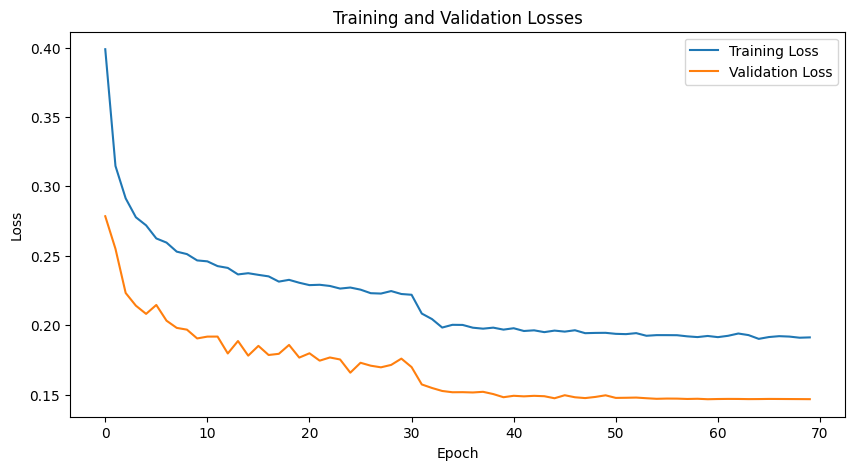

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

print(train_dataset)

X_train_tensor = train_dataset[:][0]
y_train_tensor = train_dataset[:][1]
X_val_tensor = val_dataset[:][0]
y_val_tensor = val_dataset[:][1]


# 使用模型進行預測
model_s.eval()  # 設置模型為評估模式
with torch.no_grad():
    y_train_pred = model_s(X_train_tensor)
    y_val_pred = model_s(X_val_tensor)

# 計算均方誤差 (MSE)
mse_train = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
mse_val = mean_squared_error(y_val_tensor.numpy(), y_val_pred.numpy())

# 計算均方根誤差 (RMSE)
rmse_train = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy(), squared=False)
rmse_val = mean_squared_error(y_val_tensor.numpy(), y_val_pred.numpy(), squared=False)

# 計算平均絕對誤差 (MAE)
mae_train = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
mae_val = mean_absolute_error(y_val_tensor.numpy(), y_val_pred.numpy())

# 計算R^2值
r2_train = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
r2_val = r2_score(y_val_tensor.numpy(), y_val_pred.numpy())

# 計算解釋方差分數
evs_train = explained_variance_score(y_train_tensor.numpy(), y_train_pred.numpy())
evs_val = explained_variance_score(y_val_tensor.numpy(), y_val_pred.numpy())

# 輸出結果
print(f"Training MSE: {mse_train}")
print(f"Validation MSE: {mse_val}")
print(f"Training RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_val}")
print(f"Training MAE: {mae_train}")
print(f"Validation MAE: {mae_val}")
print(f"Training R^2: {r2_train}")
print(f"Validation R^2: {r2_val}")
print(f"Training Explained Variance Score: {evs_train}")
print(f"Validation Explained Variance Score: {evs_val}")

Training MSE: 0.1313943713903427
Validation MSE: 0.146861732006073
Training RMSE: 0.33828338980674744
Validation RMSE: 0.35763105750083923
Training MAE: 0.24147339165210724
Validation MAE: 0.2537272870540619
Training R^2: 0.8687094768914152
Validation R^2: 0.852638892185107
Training Explained Variance Score: 0.8687204917271932
Validation Explained Variance Score: 0.8527116179466248


Second model(XGBoost)

In [6]:
# ##Import training Data
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# # 讀取CSV檔
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NASA_SpecToSDT/2016_2020_combined.csv', delimiter=',')
# df = df.drop(df.columns[0], axis=1)
# df['proton_temperature'] = np.log(df['proton_temperature'])

# # df_GT = df.drop(df.columns[:50], axis=1)
# # df = df.drop(df.columns[50:53], axis=1)
# threshold = 0.1 * len(df)
# df_cleaned = df.dropna(thresh=threshold, axis=1).copy()

# print(df_cleaned.shape)

# # step1. replace NAN with mean
# for column in df_cleaned.columns:
#     mean = df_cleaned[column].mean()
#     df_cleaned[column].fillna(mean, inplace=True)

# # # Step2. replace outliers with boundaries
# Q1 = df_cleaned.quantile(0.25)
# Q3 = df_cleaned.quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# for column in df_cleaned.columns:
#     df_cleaned[column] = df_cleaned[column].apply(lambda x: upper_bound[column] if x > upper_bound[column] else x)
#     df_cleaned[column] = df_cleaned[column].apply(lambda x: lower_bound[column] if x < lower_bound[column] else x)

# # # Step3. Normalization
# scaler = MinMaxScaler()
# df_normalized = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

# 轉換為numpy陣列
df_train, df_test = train_test_split(df_normalized, test_size=0.2, random_state=42)


# print(correlations)

print(data_s.shape)

(31783, 44)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:38:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


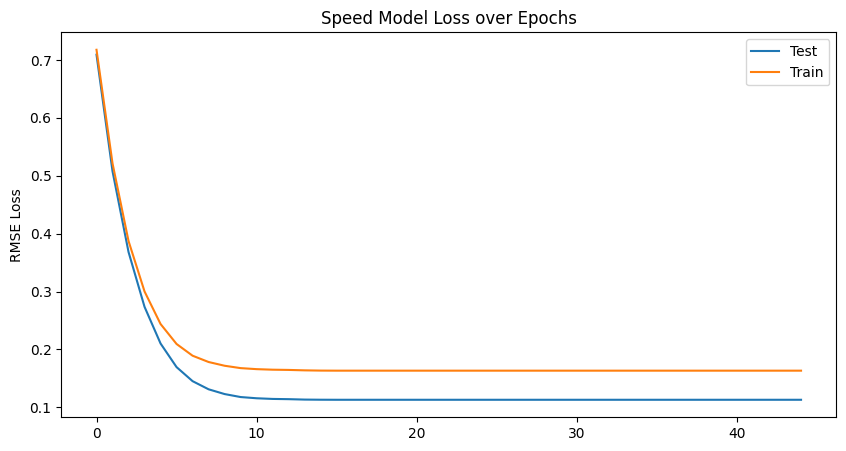

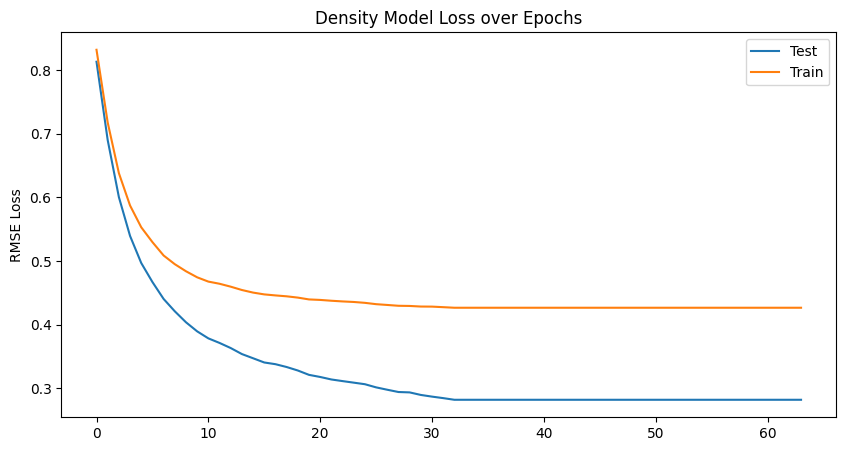

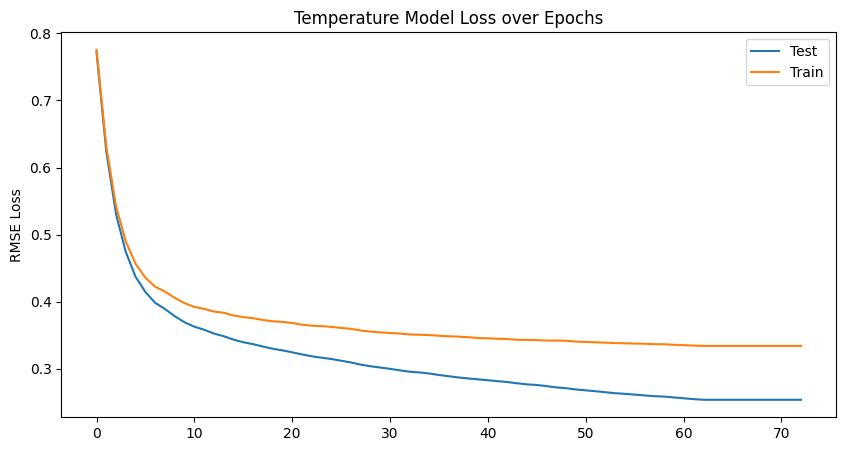

XGBoost Speed Training RMSE: 0.11299174846518523
XGBoost Speed Validation RMSE: 0.1632967940405502
-------------------------
XGBoost Density Training RMSE: 0.28201427910456045
XGBoost Density Validation RMSE: 0.4266045821085184
-------------------------
XGBoost Temperature Training RMSE: 0.25392880856558375
XGBoost Temperature Validation RMSE: 0.3342420672969641
-------------------------
XGBoost Speed prediction error: 0.026665843827917365
XGBoost Speed prediction RMSE: 0.16329679674726436
XGBoost Speed prediction MAE: 0.08391546677740443
XGBoost Speed R-squared: 0.9718990483151175
XGBoost Speed Mean Bias Deviation (%): -13.000731961884918
-------------------------
XGBoost Density prediction error: 0.18199146830971494
XGBoost Density prediction RMSE: 0.4266045807415984
XGBoost Density prediction MAE: 0.2988084284810926
XGBoost Density R-squared: 0.7727774078352921
XGBoost Density Mean Bias Deviation (%): 8.985489390189457
-------------------------
XGBoost Temperature prediction error: 

In [7]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import clone
from sklearn.model_selection import cross_val_score

params_speed = {'subsample': 1, 'n_estimators': 500, 'max_depth': 9, 'lambda': 1, 'gamma': 1, 'colsample_bytree': 1, 'alpha': 1, 'eval_metric': 'rmse','tree_method': 'hist',
'device': 'gpu'}
params_dense = {'subsample': 1, 'n_estimators': 500, 'max_depth': 9, 'lambda': 1, 'gamma': 0.1, 'colsample_bytree': 1, 'alpha': 1, 'eval_metric': 'rmse','tree_method': 'hist',
'device': 'gpu'}
params_temp = {'subsample': 1, 'n_estimators': 500, 'max_depth': 6,  'lambda': 1, 'gamma': 0.1, 'colsample_bytree': 1, 'alpha': 1, 'eval_metric': 'rmse','tree_method': 'hist',
'device': 'gpu'}
def print_metrics(predictions, y_test, model_name):
    """Print model metrics."""
    print(f"{model_name} prediction error:", mean_squared_error(predictions, y_test))
    print(f"{model_name} prediction RMSE:", np.sqrt(mean_squared_error(predictions, y_test)))
    print(f"{model_name} prediction MAE:", mean_absolute_error(predictions, y_test))
    print(f"{model_name} R-squared:", r2_score(predictions, y_test))
    print(f"{model_name} Mean Bias Deviation (%):", ((predictions - y_test) / y_test).mean() * 100)
    print("-------------------------")

def plot_xgb_loss(model, title):
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, results['validation_0']['rmse'], label='Test')  # Test set
    plt.plot(x_axis, results['validation_1']['rmse'], label='Train')  # Training set
    plt.legend()
    plt.ylabel('RMSE Loss')
    plt.title(title)
    plt.show()

def learning_rate_decay(t, initial_lr=0.1, decay_factor=0.01):
    return initial_lr / (1 + decay_factor * t)

def print_rmse_from_evals(model, model_name):
    """Print training and validation RMSE from model's evaluation results."""
    evals_result = model.evals_result()
    train_rmse = evals_result['validation_0']['rmse'][-1]
    val_rmse = evals_result['validation_1']['rmse'][-1]

    print(f"{model_name} Training RMSE: {train_rmse}")
    print(f"{model_name} Validation RMSE: {val_rmse}")
    print("-------------------------")


# Update parameters with the learning rate decay function
params_speed['learning_rate'] = learning_rate_decay
params_dense['learning_rate'] = learning_rate_decay
params_temp['learning_rate'] = learning_rate_decay


# Train individual models and make predictions
X_train = df_train.drop(columns=['proton_speed', 'proton_density', 'proton_temperature'])
y_train = df_train[['proton_speed', 'proton_density', 'proton_temperature']].values
X_test = df_test.drop(columns=['proton_speed', 'proton_density', 'proton_temperature'])
y_test = df_test[['proton_speed', 'proton_density', 'proton_temperature']].values

xgb_speed = XGBRegressor(**params_speed)
xgb_dense = XGBRegressor(**params_dense)
xgb_temp = XGBRegressor(**params_temp)

eval_set_speed = [(X_train, y_train[:, 0]), (X_test, y_test[:, 0])]
eval_set_dense = [(X_train, y_train[:, 1]), (X_test, y_test[:, 1])]
eval_set_temp = [(X_train, y_train[:, 2]), (X_test, y_test[:, 2])]

# Set a smaller early_stopping_rounds value
early_stop_rounds = 10

xgb_speed.fit(X_train, y_train[:, 0], eval_set=eval_set_speed, verbose=False, early_stopping_rounds=early_stop_rounds)
xgb_dense.fit(X_train, y_train[:, 1], eval_set=eval_set_dense, verbose=False, early_stopping_rounds=early_stop_rounds)
xgb_temp.fit(X_train, y_train[:, 2], eval_set=eval_set_temp, verbose=False, early_stopping_rounds=early_stop_rounds)

spd_preds_test = xgb_speed.predict(X_test)
den_preds_test = xgb_dense.predict(X_test)
tmp_preds_test = xgb_temp.predict(X_test)

plot_xgb_loss(xgb_speed, 'Speed Model Loss over Epochs')
plot_xgb_loss(xgb_dense, 'Density Model Loss over Epochs')
plot_xgb_loss(xgb_temp, 'Temperature Model Loss over Epochs')

print_rmse_from_evals(xgb_speed, "XGBoost Speed")
print_rmse_from_evals(xgb_dense, "XGBoost Density")
print_rmse_from_evals(xgb_temp, "XGBoost Temperature")

# Print metrics for each prediction
# Print metrics for each prediction
print_metrics(spd_preds_test, y_test[:, 0], "XGBoost Speed")
print_metrics(den_preds_test, y_test[:, 1], "XGBoost Density")
print_metrics(tmp_preds_test, y_test[:, 2], "XGBoost Temperature")

In [8]:
from sklearn.base import BaseEstimator, RegressorMixin
class DNNWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
        self._estimator_type = "regressor"

    def fit(self, X, y):
        pass

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():

            predictions = self.model(torch.tensor(X, dtype=torch.float32)).numpy()
        return predictions

    def get_params(self, deep=True):
        return {"model": self.model}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Stack XGBoost, DNN 到 Multi-Regression 然後預測

In [9]:
from sklearn.ensemble import StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
X_train = X_train.values
X_test = X_test.values

# Define the meta model
meta_model = LinearRegression()

# 定义基模型
base_models = [
    ('dnn', DNNWrapper(model_s)),
    ('xgb_speed', xgb_speed),
    ('xgb_dense', xgb_dense),
    ('xgb_temp', xgb_temp)
]

# 定义元模型
# 建立堆叠模型
stacked_model_raw = StackingRegressor(estimators=base_models, final_estimator = meta_model)

# 使用MultiOutputRegressor包装stacked_model以处理多输出
stacked_model = MultiOutputRegressor(stacked_model_raw)

# 使用原始的训练数据进行训练
stacked_model.fit(X_train, y_train)

# 进行预测

stacked_predictions = stacked_model.predict(X_test)

In [10]:
print(X_test)

[[ 0.00000000e+00  0.00000000e+00  2.84217094e-14 ...  1.13686838e-13
  -5.68434189e-14  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.84217094e-14 ...  1.13686838e-13
  -5.68434189e-14  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.84217094e-14 ...  1.13686838e-13
  -5.68434189e-14  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  2.84217094e-14 ...  1.13686838e-13
  -5.68434189e-14  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.84217094e-14 ...  1.13686838e-13
  -5.68434189e-14  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.84217094e-14 ...  1.13686838e-13
  -5.68434189e-14  0.00000000e+00]]


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
for i, output_name in enumerate(['Speed', 'Density', 'Temperature']):
    print(f"Metrics for {output_name}:")
    mse = mean_squared_error(y_test[:, i], stacked_predictions[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:, i], stacked_predictions[:, i])
    r2 = r2_score(y_test[:, i], stacked_predictions[:, i])
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R^2: {r2}")
    print("-------------------------")


Metrics for Speed:
MSE: 0.019004208322441776
RMSE: 0.13785575186564317
MAE: 0.07343486504329601
R^2: 0.9811152437577672
-------------------------
Metrics for Density:
MSE: 0.17026883208276497
RMSE: 0.4126364405657418
MAE: 0.28862558718872017
R^2: 0.8327082015908613
-------------------------
Metrics for Temperature:
MSE: 0.10006405565609527
RMSE: 0.31632903068813534
MAE: 0.22127556129016396
R^2: 0.8997573913573517
-------------------------


In [12]:
# 存模型
import joblib
joblib.dump(stacked_model, 'stacked_model.pkl')

['stacked_model.pkl']

Load model

In [13]:
# Model
# model_empty = DNN(input_size=41, hidden_sizes=[256, 128], output_size=3)
# model_s,  start_epoch = load_checkpoint(model_empty, 'best_model.pth')


To predict

In [14]:
# impport testing dataset

# 讀取CSV檔
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NASA_SpecToSDT/2021_2023_combined.csv', delimiter=',')
# print(df_test.shape)

# df_test = df_test[df_test['Predicted label'] == 0]
# df_test = df_test.reset_index(drop=True)

df_test_ts = df_test.iloc[:, 0]
df_test_gt = df_test.drop(df_test.columns[:50], axis=1).copy()
# df_test_kp = df_test[['Kp']]

df_test = df_test.drop(df_test.columns[0], axis=1)
df_test = df_test.drop(df_test.columns[41:53], axis=1)
print(df_test.shape)
# print(df_test_kp.shape)

# step1. replace NAN with median
for column in df_test.columns:
    median = df_test[column].median()
    df_test[column].fillna(median, inplace=True)

# # Step2. replace outliers with boundaries
Q1 = df_test.quantile(0.25)
Q3 = df_test.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for column in df_test.columns:
    df_test[column] = df_test[column].apply(lambda x: upper_bound[column] if x > upper_bound[column] else x)
    df_test[column] = df_test[column].apply(lambda x: lower_bound[column] if x < lower_bound[column] else x)

# # Step3. Normalization
scaler_test = StandardScaler()
df_normalized_test = pd.DataFrame(scaler_test.fit_transform(df_test), columns=df_test.columns)

# 從dataframe1中獲取列名稱
columns_to_keep = df_normalized.columns

# 確保只保留dataframe2中存在的列
columns_to_keep = [col for col in columns_to_keep if col in df_normalized_test.columns]

# 更新dataframe2
df_normalized_test = df_normalized_test[columns_to_keep]

data_test = df_normalized_test.values

# data_test = df_test.values

print(data_test)

(19798, 41)
[[-5.63277328e-01 -7.91282820e-01 -6.04886416e-01 ... -5.68434189e-14
  -5.68434189e-14  0.00000000e+00]
 [-4.00391482e-01 -7.80414959e-01 -6.34707699e-01 ... -5.68434189e-14
  -5.68434189e-14  0.00000000e+00]
 [-5.51313987e-01 -7.91794752e-01 -5.84341103e-01 ... -5.68434189e-14
  -5.68434189e-14  0.00000000e+00]
 ...
 [-1.35168627e+00 -7.91794752e-01 -1.27331442e+00 ... -5.68434189e-14
  -5.68434189e-14  0.00000000e+00]
 [-1.37051396e+00 -7.91794752e-01 -1.30850069e+00 ... -5.68434189e-14
  -5.68434189e-14  0.00000000e+00]
 [-1.37089723e+00 -7.91794752e-01 -1.31539674e+00 ... -5.68434189e-14
  -5.68434189e-14  0.00000000e+00]]


In [15]:
# # 使用模型2進行預測
# speed_predictions = xgb_speed.predict(data_test)
# density_predictions = xgb_dense.predict(data_test)
# temperature_predictions = xgb_temp.predict(data_test)

# # 將預測結果組合成一個numpy數組
# predictions_np = np.column_stack([speed_predictions, density_predictions, temperature_predictions])
# predictions_df = pd.DataFrame(predictions_np, columns=['proton_speed', 'proton_density', 'proton_temperature'])
# print(predictions_df.shape)
# predictions_combined = pd.concat([df_normalized_test, predictions_df], axis=1)
# print(predictions_combined.shape)

# # 反轉術式
# df_original_2 = pd.DataFrame(scaler.inverse_transform(predictions_combined), columns = df_normalized.columns)
# # df_original_2['proton_temperature'] = np.exp(df_original_2['proton_temperature'])
# print(df_original_2.iloc[:,-3:])

In [16]:
# # 使用模型1進行預測
# X_tensor = torch.tensor(data_test, dtype=torch.float32)
# model_s.eval()
# with torch.no_grad():
#     predictions = model_s(X_tensor)

# predictions_numpy = predictions.numpy()

# # 將預測結果組合成一個numpy數組
# predictions_df = pd.DataFrame(predictions_numpy, columns=['proton_speed', 'proton_density', 'proton_temperature'])
# predictions_combined = pd.concat([df_test, predictions_df], axis=1)
# print(predictions_combined.shape)

# # 反轉術式
# df_original_1 = pd.DataFrame(scaler.inverse_transform(predictions_combined), columns = df_cleaned.columns)
# # df_original_1['proton_temperature'] = np.exp(df_original_1['proton_temperature'])
# print(df_original_1.iloc[:,-3:])

拿ground truth 來做比較

In [17]:
# Weigthed prediction
predictions = stacked_model.predict(data_test)

predictions_df = pd.DataFrame(predictions, columns=['proton_speed', 'proton_density', 'proton_temperature'])
predictions_combined = pd.concat([df_test, predictions_df], axis=1)

result = pd.DataFrame(scaler.inverse_transform(predictions_combined), columns = df_cleaned.columns)
print(result['proton_temperature'])
result['proton_temperature'] = np.exp(result['proton_temperature'])
result = result.iloc[:,-3:]

# Ground truth
df_test_gt = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NASA_SpecToSDT/2021_2023_combined.csv', delimiter=',')

# df_weighted_result = pd.concat([df_test_ts, df_weighted], axis=1)
# df_weighted_result = pd.concat([df_weighted_result, df_test_kp], axis=1)
# print(df_weighted_result)
# df_weighted_result.to_csv('/content/drive/My Drive/Colab Notebooks/NASA_SpecToSDT/Predicted_SDT.csv', index=False)

df_test_gt = df_test_gt.drop(df_test_gt.columns[0], axis=1)
df_test_gt = df_test_gt.iloc[:, -3:]
# df_test_gt.iloc[:, 2] = np.log(df_test_gt.iloc[:, 2])

print(result)

print(df_test_gt.iloc[:,-3:])

# Calculate the error = (pred - gt)
df_error = (result - df_test_gt)
print(df_error)

0        12.036517
1        11.327247
2        12.028270
3        12.019692
4        11.939433
           ...    
19793    11.572459
19794    11.477229
19795    11.655316
19796    11.388631
19797    11.575171
Name: proton_temperature, Length: 19798, dtype: float64
       proton_speed  proton_density  proton_temperature
0        378.831310        3.581388       168807.976659
1        378.006031        4.291072        83054.068640
2        377.387887        3.848415       167421.562324
3        377.449847        3.839643       165991.539261
4        375.236726        4.201702       153189.856230
...             ...             ...                 ...
19793    392.035341        2.813063       106134.147445
19794    412.458084        2.633493        96493.290086
19795    408.549602        2.659403       115302.630239
19796    421.641139        2.540916        88311.977253
19797    434.276236        2.090735       106422.381602

[19798 rows x 3 columns]
       proton_speed  proton_density  

Mean Absolute Error (MAE): 86117.5951091627
Mean Squared Error (MSE): 17595007011.77612
Root Mean Squared Error (RMSE): 132646.17224698237
Median Absolute Error: 64645.97157737789
Max Error: 637797.8724101953
Min Error: -1628768.1244790456


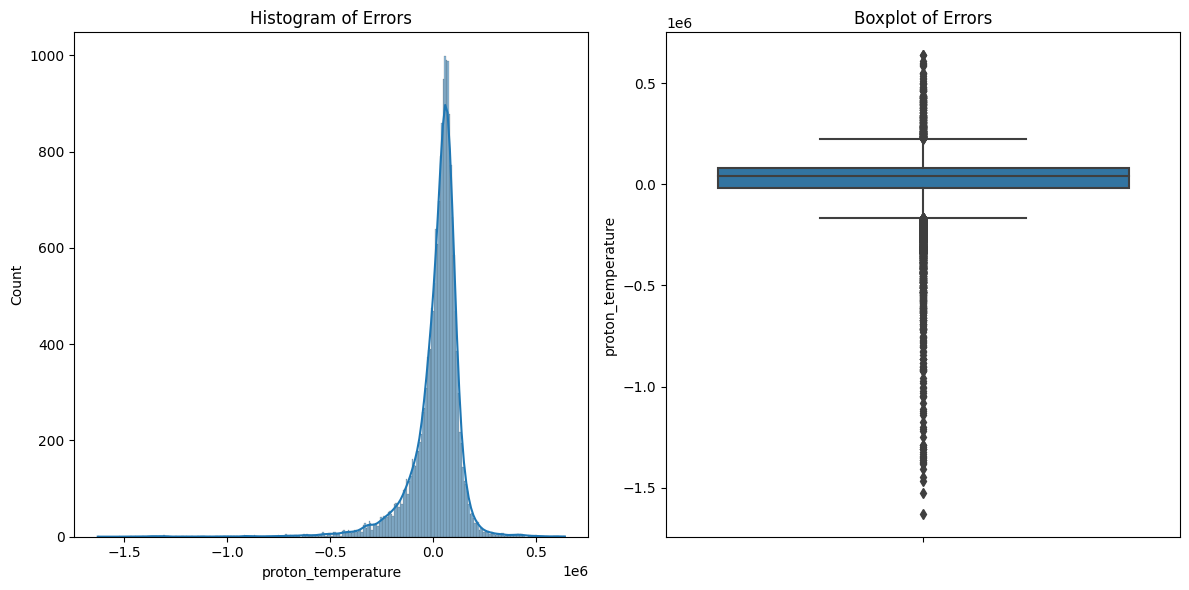

In [18]:
# Output CSV fileimport pandas as pd
import seaborn as sns

# 假设您的DataFrame名为df
statistics = df_error.describe()

def evaluate_errors(errors):
    mae = np.mean(np.abs(errors))
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    median_abs_error = np.median(np.abs(errors))
    max_error = np.max(errors)
    min_error = np.min(errors)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Median Absolute Error: {median_abs_error}")
    print(f"Max Error: {max_error}")
    print(f"Min Error: {min_error}")

    # 繪製誤差的分佈
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(errors, kde=True)
    plt.title("Histogram of Errors")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=errors)
    plt.title("Boxplot of Errors")

    plt.tight_layout()
    plt.show()

evaluate_errors(df_error.iloc[:,2])



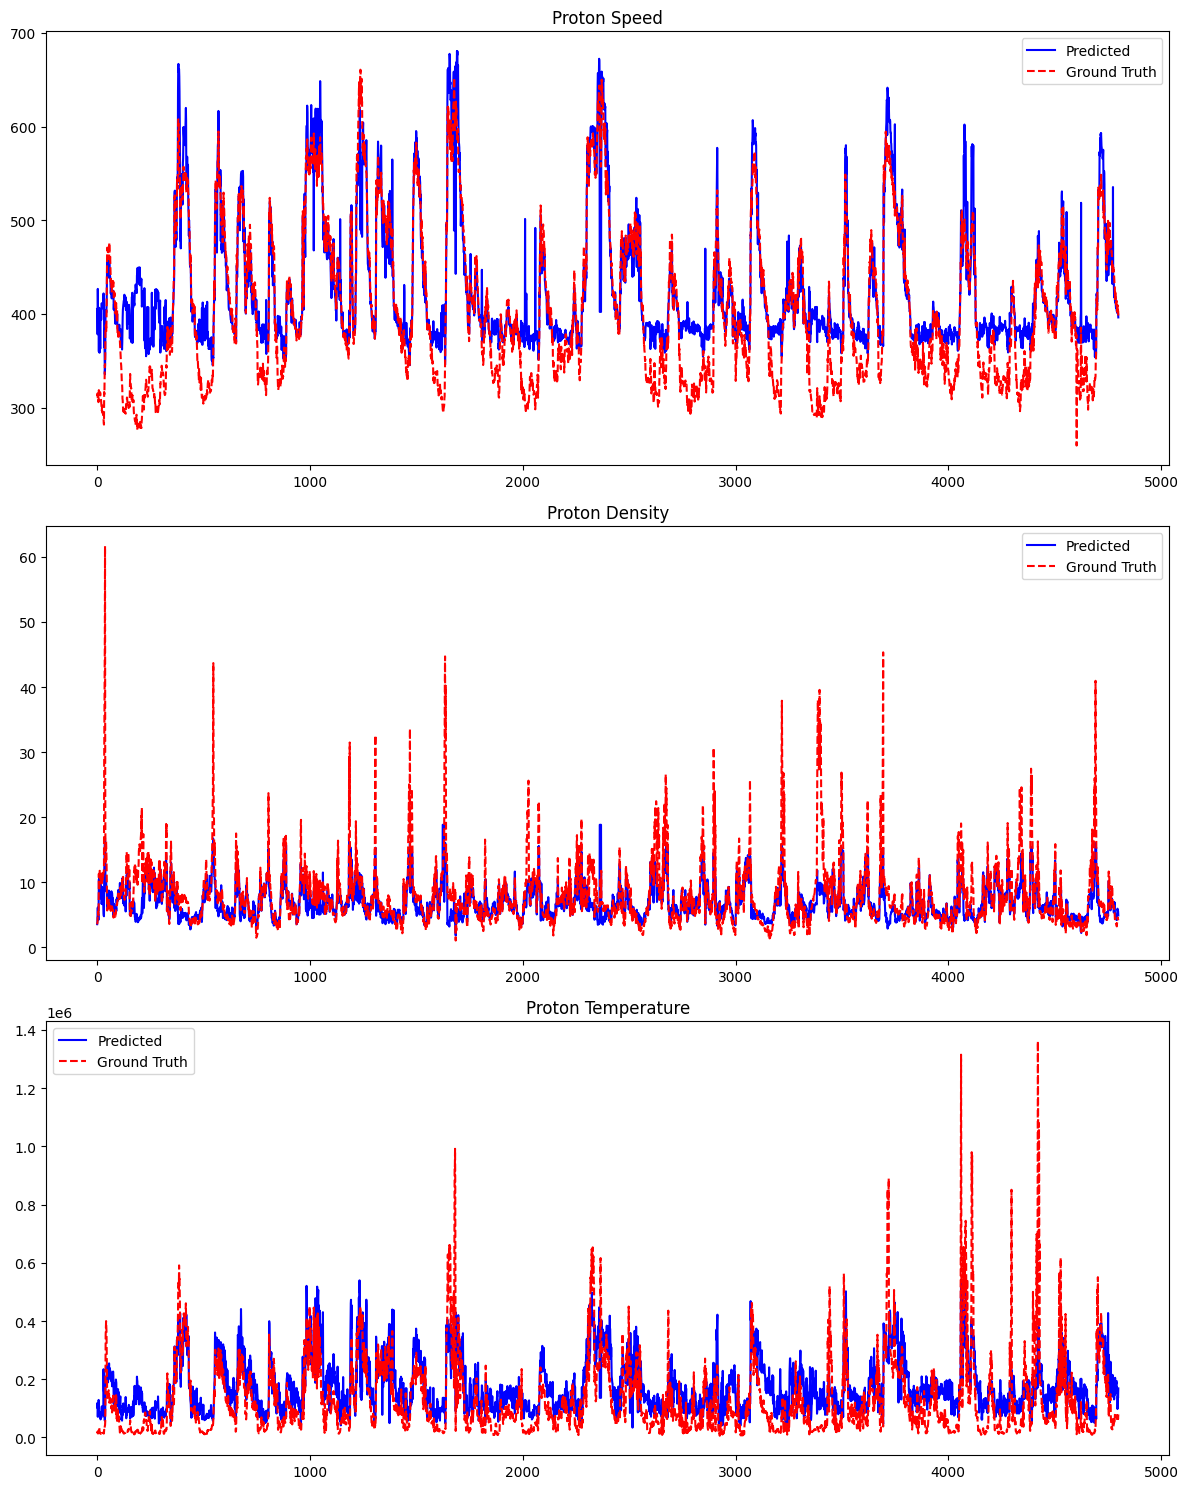

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Plotting proton_speed
axs[0].plot(result.values[200:5000, 0], label='Predicted', color='blue')
axs[0].plot(df_test_gt.values[200:5000, 0], label='Ground Truth', color='red', linestyle='dashed')
axs[0].set_title('Proton Speed')
axs[0].legend()

# Plotting proton_density
axs[1].plot(result.values[200:5000, 1], label='Predicted', color='blue')
axs[1].plot(df_test_gt.values[200:5000, 1], label='Ground Truth', color='red', linestyle='dashed')
axs[1].set_title('Proton Density')
axs[1].legend()

# Plotting proton_temperature
axs[2].plot(result.values[200:5000, 2], label='Predicted', color='blue')
axs[2].plot(df_test_gt.values[200:5000, 2], label='Ground Truth', color='red', linestyle='dashed')
axs[2].set_title('Proton Temperature')
axs[2].legend()

plt.tight_layout()
plt.show()

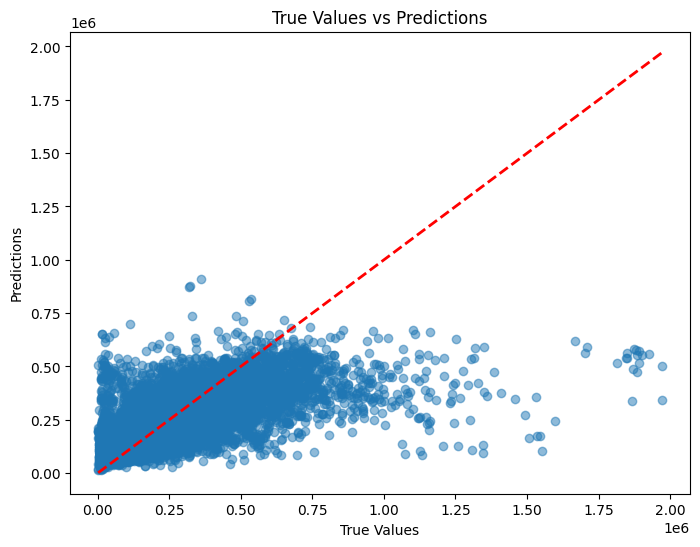

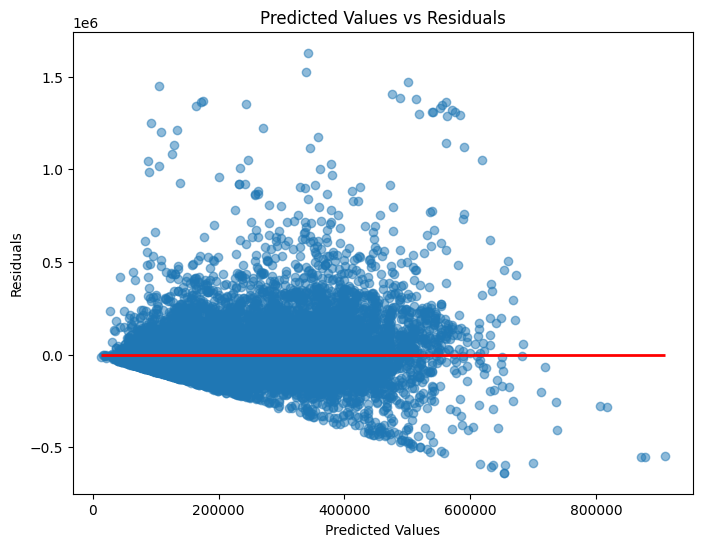

In [19]:
S# Visualization

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 假設您已經有了預測值和真實值
y_true = df_test_gt.iloc[:,2]  # 真實值
y_pred = result.iloc[:,2]  # 模型的預測值

# 散點圖
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--r', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

# 殘差圖
residuals = y_true - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(0, min(y_pred), max(y_pred), colors='r', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Predicted Values vs Residuals')
plt.show()

# 檢查模型的偏差和方差

# 將數據分為訓練集和驗證集
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 假設您已經有了一個模型，例如model
# model = YourModel()

# 訓練模型
# model.fit(X_train, y_train)

# 在訓練集和驗證集上進行預測
# y_train_pred = model.predict(X_train)
# y_val_pred = model.predict(X_val)

# 計算MSE
# train_mse = mean_squared_error(y_train, y_train_pred)
# val_mse = mean_squared_error(y_val, y_val_pred)

# 印出MSE以評估偏差和方差
# print(f"Training MSE: {train_mse}")
# print(f"Validation MSE: {val_mse}")

# 如果train_mse >> val_mse，可能存在過擬合
# 如果train_mse和val_mse都很高，可能存在欠擬合


In [20]:
import numpy as np
from collections import Counter
np.random.seed(42)
arrayGT = np.random.rand(10000, 3)
arrayPred = np.random.rand(10000, 3)

def abnormal_indicesarrayGT(arrayGT,arrayPred):
    relative_error = (arrayGT - arrayPred) / arrayGT
    outlier_indices = []
    for feature_idx in range(relative_error.shape[1]):
        feature_data = relative_error[:, feature_idx]
        # mean = np.mean(feature_data)
        # std = np.std(feature_data)
        # upper_limit = mean + 3 * std
        # lower_limit = mean - 3 * std
        median = np.median(feature_data)
        q1 = np.percentile(feature_data, 25)
        q3 = np.percentile(feature_data, 75)
        iqr = q3 - q1
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr
        outliers = np.where((feature_data > upper_limit) | (feature_data < lower_limit))[0]
        outlier_indices.append(outliers)
    all_outlier_indices = [idx for indices in outlier_indices for idx in indices]
    index_counts = Counter(all_outlier_indices)
    common_outliers = [idx for idx, count in index_counts.items() if count >= 3]
    outlier_flag = [0] * df_error.shape[0]
    for idx in common_outliers:
        outlier_flag[idx] = 1
    return outlier_flag

outlier_flag = abnormal_indicesarrayGT(df_test_gt.values,result.values)

df_test_final = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NASA_SpecToSDT/2021_2023_combined.csv', delimiter=',')
df_test_final['Label'] = outlier_flag

df_test_final.to_csv('/content/drive/My Drive/Colab Notebooks/NASA_SpecToSDT/relabeled_2021-2023_ol_3.csv', index=False)


